# Regression Project: AirBNB Price Prediction

Coded by Luna McBride

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from mpl_toolkits.basemap import Basemap #Plot onto map
import matplotlib.pyplot as plt #Plotting
%matplotlib inline

plt.rcParams['figure.figsize'] = (15,10) #Set the default figure size
plt.style.use('ggplot') #Set the plotting method

from sklearn.model_selection import train_test_split #Split the data into train and test
from sklearn.ensemble import RandomForestRegressor #Forest for prediction and regression
from sklearn.linear_model import LinearRegression #Regression for prediction
from sklearn.preprocessing import StandardScaler #Scale the data
from sklearn.metrics import mean_squared_error #Error testing

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-airbnb-open-data/AB_US_2020.csv


In [2]:
bnb = pd.read_csv("../input/us-airbnb-open-data/AB_US_2020.csv") #Read the airbnb csv
bnb.head() #Take a peek at the dataset

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


In [3]:
bnb["price"] = bnb["price"].apply(lambda x: 1 if x < 1 else x) #Make 0's 1 so the log function works

In [4]:
#Print some attributes about the prices
print("Max Price: ", np.max(bnb["price"]))
print("Min Price: ", np.min(bnb["price"]))
print("Num Prices Below 20: ", len(bnb.loc[bnb["price"] < 20]))
print("Num Prices Above 1000: ", len(bnb.loc[bnb["price"] > 1000]))
print("Num Locations", len(bnb))

Max Price:  24999
Min Price:  1
Num Prices Below 20:  559
Num Prices Above 1000:  4578
Num Locations 226030


---

# Check for Null Values

In [5]:
print(bnb.isnull().any()) #Check for null values

id                                False
name                               True
host_id                           False
host_name                          True
neighbourhood_group                True
neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
last_review                        True
reviews_per_month                  True
calculated_host_listings_count    False
availability_365                  False
city                              False
dtype: bool


In [6]:
print(bnb.loc[bnb["reviews_per_month"].isnull()]) #See where reviews_per_month is null

              id                                               name  \
187      6775949                Cozy Cottage short walk to Downtown   
286     12182918        MONTHLY - Grove Park - Charming Guest House   
416     15359380          5 Points Bungalow, Your Home in Asheville   
629     20255923      Sunrise Perch - High on a mountain & close-in   
720     21513021       2 Bedroom Condo blocks to Downtown Asheville   
...          ...                                                ...   
226025  45506143                          DC Hidden In Plain "Site"   
226026  45511428  DC 3 BR w/ screen porch 3 blck to metro w/ par...   
226027  45514685  Charming Penthouse Apt w/ Rooftop Terrace in L...   
226028  45516412                Adams Morgan/Nat'l Zoo 1 BR Apt #32   
226029  45517735    Beautiful large one-bedroom w/ washer and dryer   

          host_id         host_name neighbourhood_group  \
187      35473023            Sherri                 NaN   
286        183656            

Reviews_Per_Month and Last_Review appear to be null when there are no nulls. The best way to fill these would probably be to make Reviews_Per_Month 0 and a dummy date for last review (01-01-01). This data field will have to be fixed into yyyy-mm-dd anyway, so a non-date value will cause problems.

In [7]:
print(bnb.loc[bnb["host_name"].isnull()]) #See where host_name is null

              id                                               name  \
3129     4356661                   1 BR 1 Bath DT Apt [W/D in unit]   
3866     8214182                Private room  in all female housing   
7619    27025549    Studio apt in prime central Austin free parking   
17727   16879934  HUGE LAKE VIEW MASTER BDRM  (sleeps 2) near we...   
17995   18406577                                         comfy home   
18913   22560010                                         Comfy Home   
76723    6900415                          Quiet, Cozy West LA House   
78167   10034835                     Large private bedroom in Palms   
83235   19410610                          Cozy Home Away From Home!   
83948   20450454                               Venice Artista House   
96175   38358017  Modern Beachfront Guest Suite Hidden Ocean Escape   
100462  42697243   Private Master Room with Private Bath in West LA   
105755  15820455                 1 BR Condo Downtown/Nissan Stadium   
122099

In [8]:
print(bnb.loc[bnb["name"].isnull()]) #See where name is null

              id name    host_id  host_name neighbourhood_group  \
23691   39717529  NaN  305261435      Patti                 NaN   
81872   17108083  NaN  114871749     Karina        Other Cities   
93004   33877948  NaN  141228320    Marquis        Other Cities   
119475   1615764  NaN    6676776      Peter           Manhattan   
120149   2232600  NaN   11395220       Anna           Manhattan   
121853   4209595  NaN   20700823      Jesse           Manhattan   
122016   4370230  NaN   22686810   Micha√´l           Manhattan   
122265   4581788  NaN   21600904      Lucie            Brooklyn   
122513   4756856  NaN    1832442   Carolina            Brooklyn   
122544   4774658  NaN   24625694       Josh           Manhattan   
124383   6782407  NaN   31147528   Huei-Yin            Brooklyn   
126967   9325951  NaN   33377685   Jonathan           Manhattan   
127629   9787590  NaN   50448556     Miguel           Manhattan   
127822   9885866  NaN   37306329   Juliette           Manhatta

Both name and host_name do not inherently have any importance since their ID's are what is important. I can decide what to drop later after more exploration, so I will fill these with generic, obviously filled in names. I am thinking "AIRBNB HOUSING" and "AIRBNB HOST".

As for neighborhood_group, it appears this is just here to emphasize certain areas of cities like New York. I will change nulls to "Other" in this case, as not all cities have neighborhoods like New York. The neighborhood names (besides NY) also seem inconsistent when looking at it through the other null prints, so that is something to keep in mind.

---

# Fix the Null Values

In [9]:
bnb["name"] = bnb["name"].fillna("AIRBNB HOUSING") #Fill the null name values with "AIRBNB HOUSING"
print(bnb.loc[bnb["name"] == "AIRBNB HOUSING"]) #See where name is fixed to make sure this works

              id            name    host_id  host_name neighbourhood_group  \
23691   39717529  AIRBNB HOUSING  305261435      Patti                 NaN   
81872   17108083  AIRBNB HOUSING  114871749     Karina        Other Cities   
93004   33877948  AIRBNB HOUSING  141228320    Marquis        Other Cities   
119475   1615764  AIRBNB HOUSING    6676776      Peter           Manhattan   
120149   2232600  AIRBNB HOUSING   11395220       Anna           Manhattan   
121853   4209595  AIRBNB HOUSING   20700823      Jesse           Manhattan   
122016   4370230  AIRBNB HOUSING   22686810   Micha√´l           Manhattan   
122265   4581788  AIRBNB HOUSING   21600904      Lucie            Brooklyn   
122513   4756856  AIRBNB HOUSING    1832442   Carolina            Brooklyn   
122544   4774658  AIRBNB HOUSING   24625694       Josh           Manhattan   
124383   6782407  AIRBNB HOUSING   31147528   Huei-Yin            Brooklyn   
126967   9325951  AIRBNB HOUSING   33377685   Jonathan          

In [10]:
bnb["host_name"] = bnb["host_name"].fillna("AIRBNB HOST") #Fill the null host name values with "AIRBNB HOST"
print(bnb.loc[bnb["host_name"] == "AIRBNB HOST"]) #See where host_name is fixed to make sure this works

              id                                               name  \
3129     4356661                   1 BR 1 Bath DT Apt [W/D in unit]   
3866     8214182                Private room  in all female housing   
7619    27025549    Studio apt in prime central Austin free parking   
17727   16879934  HUGE LAKE VIEW MASTER BDRM  (sleeps 2) near we...   
17995   18406577                                         comfy home   
18913   22560010                                         Comfy Home   
76723    6900415                          Quiet, Cozy West LA House   
78167   10034835                     Large private bedroom in Palms   
83235   19410610                          Cozy Home Away From Home!   
83948   20450454                               Venice Artista House   
96175   38358017  Modern Beachfront Guest Suite Hidden Ocean Escape   
100462  42697243   Private Master Room with Private Bath in West LA   
105755  15820455                 1 BR Condo Downtown/Nissan Stadium   
122099

In [11]:
bnb["neighbourhood_group"] = bnb["neighbourhood_group"].fillna("Other") #Fill the null neighbourhood group values with "Other"

In [12]:
bnb["reviews_per_month"] = bnb["reviews_per_month"].fillna(0) #Fill the null reviews_per_month values with 0

In [13]:
bnb["last_review"] = bnb["last_review"].fillna("01/01/01") #Fill the null last_review values with 01/01/01
bnb["last_review"] = pd.to_datetime(bnb["last_review"]) #Convert the last review to datetime
print(bnb["last_review"]) #Print the last review

0        2020-02-16
1        2020-07-09
2        2019-11-30
3        2020-09-22
4        2015-10-19
            ...    
226025   2001-01-01
226026   2001-01-01
226027   2001-01-01
226028   2001-01-01
226029   2001-01-01
Name: last_review, Length: 226030, dtype: datetime64[ns]


In [14]:
print(bnb.isnull().any()) #Check for null values

id                                False
name                              False
host_id                           False
host_name                         False
neighbourhood_group               False
neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
last_review                       False
reviews_per_month                 False
calculated_host_listings_count    False
availability_365                  False
city                              False
dtype: bool


All of the null values have been fixed.

---

# Fix Column Names for My Comfort

In [15]:
#Change the column names to ones I prefer
bnb = bnb.rename(columns = {"host_id" : "hostId", "host_name" : "hostName", "neighbourhood_group" : "neighGroup",
                            "neighbourhood" : "neigh", "room_type" : "roomType", "minimum_nights" : "minNights",
                            "number_of_reviews" : "numReviews", "last_review" : "lastReview", "reviews_per_month" : "monthlyReviews",
                            "calculated_host_listings_count" : "numListings", "availability_365" : "available"})
bnb.head() #Take a peek at the dataset

,id,name,hostId,hostName,neighGroup,neigh,latitude,longitude,roomType,price,minNights,numReviews,lastReview,monthlyReviews,numListings,available,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,Other,28804,35.65146,-82.62792,Private room,60,1,138,2020-02-16,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,Other,28801,35.59779,-82.55540,Entire home/apt,470,1,114,2020-07-09,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,Other,28801,35.60670,-82.55563,Entire home/apt,75,30,89,2019-11-30,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,Other,28806,35.57864,-82.59578,Entire home/apt,90,1,267,2020-09-22,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,Other,28801,35.61442,-82.54127,Private room,125,30,58,2015-10-19,0.52,1,0,Asheville


---

# AirBNB Locations

Source: https://basemaptutorial.readthedocs.io/en/latest/subplots.html , Basemap Documentation

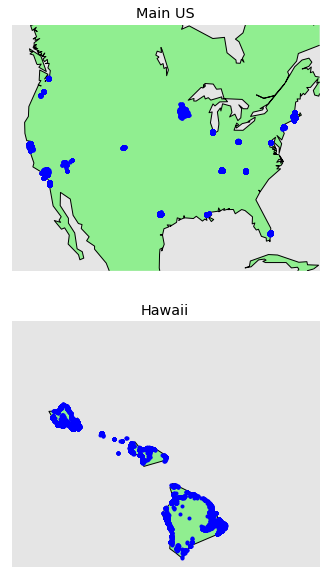

In [16]:
fig = plt.figure() #Plot figure to add subplots
lat = list(bnb["latitude"]) #Get the list of latitudes
lon = list(bnb["longitude"]) #Get the list of longitudes

ax = fig.add_subplot(211) #Add a subplot for the contiguous US
ax.set_title("Main US") #Add a title for the main US

#Set a basemap for the contiguous United States
mUS = Basemap(width = 5000000, height = 4000000, projection = "lcc",
            resolution = "c", lat_1 = 35.0, lat_2 = 45.0, lat_0 = 40.0, lon_0 = -97.0)

mUS.drawcoastlines() #Draw the coastlines
mUS.fillcontinents(color = "lightgreen") #Make the land light green
xlon, ylat = mUS(lon, lat) #Fit the coordinates to fit with the map
mUS.plot(xlon, ylat, "b.") #Plot the US with our AirBNB data

ax = fig.add_subplot(212) #Add a subplot for Hawaii
ax.set_title("Hawaii") #Set title to hawaii

#Set a basemap for Hawaii
mH = Basemap(width=625000,height=500000,projection='lcc',
            resolution='l',lat_1=16.,lat_2=26,lat_0=21,lon_0=-156.)

mH.drawcoastlines() #Draw the coastline
mH.fillcontinents(color = "lightgreen") #Make the land light green
xlon, ylat = mH(lon, lat) #Fit the coordinates into the map
mH.plot(xlon, ylat, "b.") #Plot the AirBNB data

plt.show() #Show the maps

Hawaii is littered with AirBNB locations. I should check the data to make sure that makes sense.

In [17]:
print(bnb["city"].unique()) #See all the unique "cities" in the data

['Asheville' 'Austin' 'Boston' 'Broward County' 'Cambridge' 'Chicago'
 'Clark County' 'Columbus' 'Denver' 'Hawaii' 'Jersey City' 'Los Angeles'
 'Nashville' 'New Orleans' 'New York City' 'Oakland' 'Pacific Grove'
 'Portland' 'Rhode Island' 'Salem' 'San Clara Country' 'San Diego'
 'San Francisco' 'San Mateo County' 'Santa Cruz County' 'Seattle'
 'Twin Cities MSA' 'Washington D.C.']


In [18]:
hawaii = len(bnb.loc[bnb["city"] == "Hawaii"]) #Get the number of Hawaii Locations
print("Number of Hawaii Locations: {}".format(hawaii)) #Print the number of hawaii locations
print("Percent of Hawaii Locations in Dataset: {}".format( hawaii / len(bnb))) #Print the proportion of hawaii locations

Number of Hawaii Locations: 22434
Percent of Hawaii Locations in Dataset: 0.09925231164004777


Hawaii accounts for a massive 10% of the dataset at 22434 locations. The map is justified.

---

# Fix City Names into Major Areas

In [19]:
#A list of areas in the dataset that are part of the San Francisco major area
SF = ["Oakland", "Pacific Grove", "San Clara Country", "Santa Cruz County", "San Mateo County", "San Francisco"]

#Fix the cities into their major areas
#Input: the city/state/county named state (this column has so many different things)
#Output: the fixed label
def fixState(state):
    
    #Fix the labels whose major areas are not as clear
    if state == "Broward County":
        return "Miami"
    if state == "Twin Cities MSA":
        return "Minneapolis"
    if state == "Clark County":
        return "Las Vegas"
    
    #Lump labels together if thier major area is the same
    if state == "Boston" or state == "Cambridge":
        return "Boston"
    if state == "Portland" or state == "Salem":
        return "Portland"
    if state == "Jersey City":
        return "New York City"
    if state in SF:
        return "San Francisco"
    
    return state #Return the label if it does not need to change

bnb["city"] = bnb["city"].apply(fixState) #Fix the city column with its major areas

---

# Visualize Major Areas

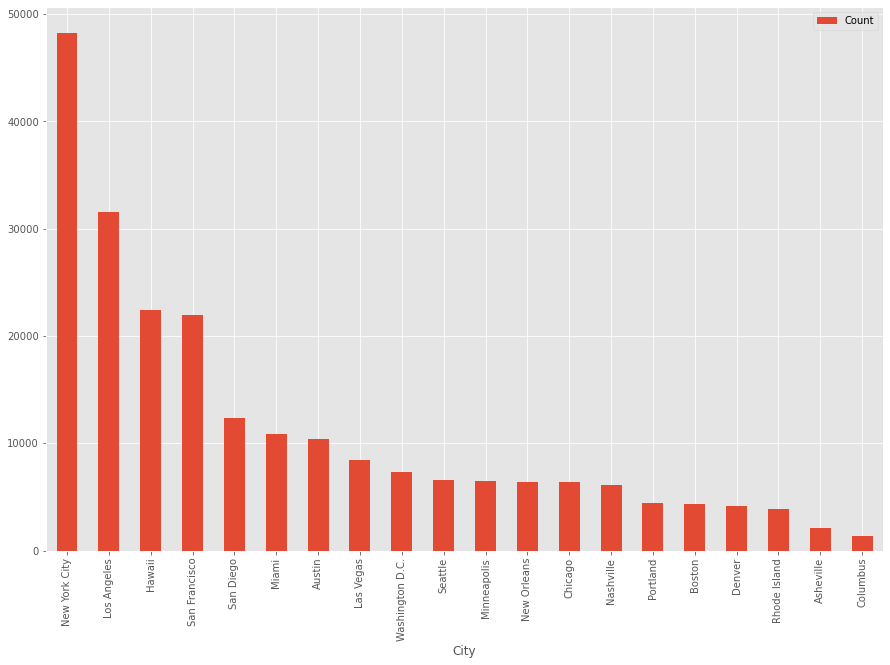

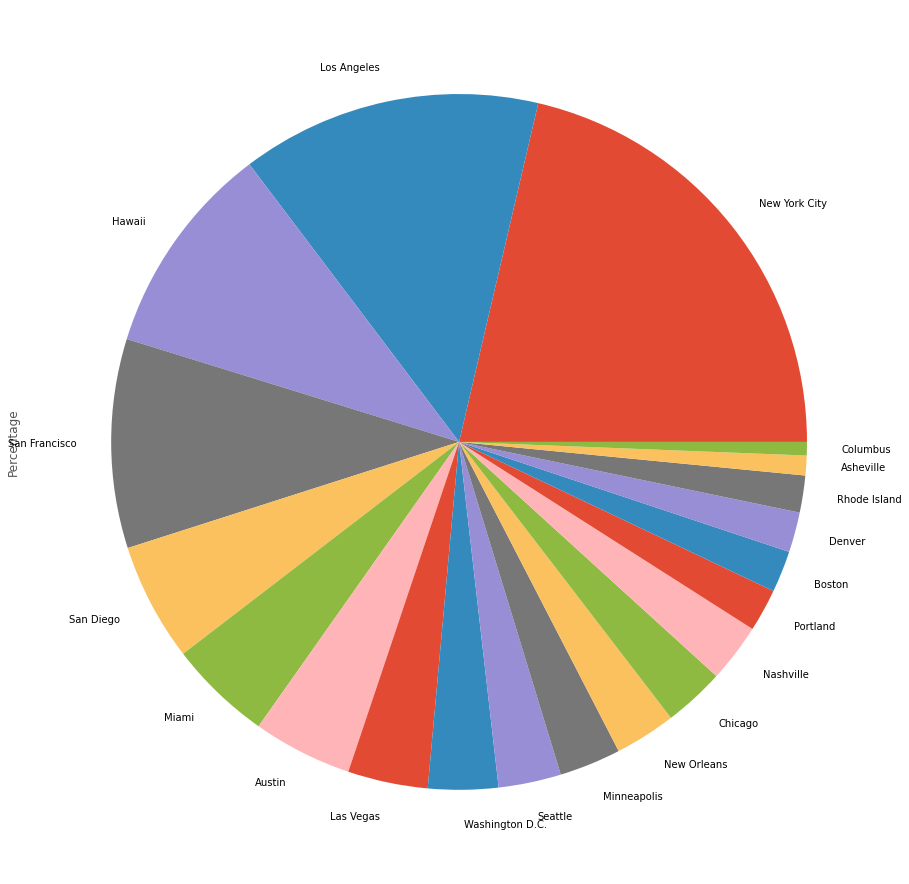

In [20]:
percentages = [] #A list variable to hold the percentages of overall listings in each major area
counts = [] #A list variable to hold the counts of each major area
cities = bnb["city"].unique() #Get the unique major areas to loop through

#For each major area, get its number of listings and the proportion of the overall data that count takes up
for city in cities:
    cityCount = len(bnb.loc[bnb["city"] == city]) #Get the number of listings in that city/major area
    counts.append((city, cityCount)) #Append the count with its city name into the counts list
    percentages.append((city, cityCount/len(bnb))) #Append the proportion (Percent) for the city into the percentages list
    
cityDF = pd.DataFrame(counts, columns = ["City", "Count"]) #Put the count list into a dataframe
perDF = pd.DataFrame(percentages, columns = ["City", "Percentage"]) #Put the percentage list into a dataframe
cityDF = cityDF.join(perDF.set_index("City"), on = "City") #Join the percentage and count sets

cityCount = cityDF.sort_values("Count", ascending = False) #Sort the joined datafrmame by its counts
cityCount.plot.bar(x = "City", y = "Count") #Plot the counts for each city in a bar graph

cityPer = cityDF.sort_values("Percentage", ascending = False) #Sort the joined dataframe by its percentage proportions
cityPer = cityPer.set_index("City") #Set the index to city so the pie chart function works correctly
cityPer.plot.pie(y = "Percentage", fontsize = 10, legend = False, figsize = (24, 16)) #Plot a pie chart of city proportions in the dataset

This dataset appears to ignore relatively smaller areas, but this should not cause problems.

---

# Regression on the Overall Dataset

(I will be using a Random Forest Regression, as that proved best when I compared regression accuracies in a previous project).

## Split the Data

In [21]:
price = bnb["price"].copy() #Take the price as its own variable. That is what we are looking for
price = np.log(price) #Take the log of the set for normalization

In [22]:
print(bnb.loc[bnb["price"] > 10000])

              id                                               name  \
1845    42513939                                  Almost Heaven Too   
1846    42513942                                      Almost Heaven   
1950    43924301  Haw Creek Escape: Right on the doorstep of Dow...   
9432    36868625                            Sapphire on Lake Austin   
55106   18635070  4 Bedrooms! New Listing! Pool! Ocean Views! Go...   
56120   20472161                                Royal Kailua Estate   
56173   20475425                                     Thousand Waves   
56176   20475538              The Sullivan Estate & JK7 SPA Retreat   
57668   22635984  Dancing Bamboo Cottage - Minutes from Hawaii V...   
58512   24231447                               Kailua Shores Estate   
60450   28487396                                  Kauhale Pilialoha   
61834   30963153  Kamaole Sands #9-207 Tastefully Decorated 1Bd/...   
61875   30963343  Kihei Bay Surf #257 Remodeled 2nd Flr Studio, ...   
61913 

In [23]:
characteristics = bnb.copy() #Take a copy of the dataframe for usage
characteristics = characteristics.drop(columns = {"price"}) #Remove the price, since we cannot predict price if it is already there
characteristics.head() #Take a peek at the data without the price

,id,name,hostId,hostName,neighGroup,neigh,latitude,longitude,roomType,minNights,numReviews,lastReview,monthlyReviews,numListings,available,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,Other,28804,35.65146,-82.62792,Private room,1,138,2020-02-16,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,Other,28801,35.59779,-82.55540,Entire home/apt,1,114,2020-07-09,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,Other,28801,35.60670,-82.55563,Entire home/apt,30,89,2019-11-30,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,Other,28806,35.57864,-82.59578,Entire home/apt,1,267,2020-09-22,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,Other,28801,35.61442,-82.54127,Private room,30,58,2015-10-19,0.52,1,0,Asheville


There are several columns that I should not take into account here. The name and hostName columns are all considered categorical data filled with the entirely different values, so there is not nearly enough memory to handle pandas bringing that to dummies. The same goes for lastReview if left as a string. As a datetime (which I set it to), the scaler does not recognize it. Then there is neigh, which I actually tried to use. It turned fitting the model into an hour long endeavor due to it creating a lot of dummy variables and only increased accuracy by about 3%. The trade off for that one is not worth it.

In [24]:
charact = characteristics.drop(columns = {"name", "hostName",  "neigh", "lastReview"}) #Remove the variables discussed above
charact.head() #Take a peek at the data after removing the variables

,id,hostId,neighGroup,latitude,longitude,roomType,minNights,numReviews,monthlyReviews,numListings,available,city
0,38585,165529,Other,35.65146,-82.62792,Private room,1,138,1.14,1,0,Asheville
1,80905,427027,Other,35.59779,-82.55540,Entire home/apt,1,114,1.03,11,288,Asheville
2,108061,320564,Other,35.60670,-82.55563,Entire home/apt,30,89,0.81,2,298,Asheville
3,155305,746673,Other,35.57864,-82.59578,Entire home/apt,1,267,2.39,5,0,Asheville
4,160594,769252,Other,35.61442,-82.54127,Private room,30,58,0.52,1,0,Asheville


In [25]:
charact = pd.get_dummies(charact) #Get the dummies for easier model training
scale = StandardScaler() #Add a standard scaler to scale our data for easier use later
scale.fit(charact) #Fit the scaler with our characteristics
chara = scale.transform(charact) #Transform the data with our scaler

In [26]:
print(len(chara[0])) #Print the scaled data

68


In [27]:
charaTrain, charaTest, priceTrain, priceTest = train_test_split(chara, price, test_size = 0.1) #Split the data into train and test
print(priceTest) #Print one of the splits

112654    6.163315
123130    4.382027
153595    3.912023
210142    5.068904
10093     6.018593
            ...   
221833    4.043051
56000     5.820083
78214     4.442651
188518    5.978886
25565     7.021976
Name: price, Length: 22603, dtype: float64


## Fit the Forest Regressor

In [28]:
forest = RandomForestRegressor(n_estimators = 150) #Build a whole forest of trees
forest.fit(charaTrain, priceTrain) #Fit the forest

RandomForestRegressor(n_estimators=150)

In [29]:
predict = forest.predict(charaTest) #Get the predictions for RMSE

In [30]:
overallAccuracy = ("Overall", forest.score(charaTest, priceTest)) #Get the overall accuracy
print("Forest Accuracy: ", forest.score(charaTest, priceTest)) #Print the accuracy
print("Root Mean Square Error: ", np.sqrt(mean_squared_error(priceTest, predict))) #Print the root mean square error

Forest Accuracy:  0.5976821029648307
Root Mean Square Error:  0.5385343004041514


In [31]:
attributes = charact.columns #Get the tested attributes
attributes = list(zip(attributes, forest.feature_importances_)) #Zip the attributes together with their coefficient
sortAtt = sorted(attributes, key = lambda x: x[1], reverse = True) #Sort the zipped attributes by their coefficients

print("According to the Random Forest (most accurate), the most important factors for pricing are: ") #Start printing the most important labels
i=0 #Counter variable so only the top five are printed

#For each attribute in the sorted attributes
for label, coef in sortAtt:
    if i<5: #If there has not been five printed yet
        print(label) #Print the label as an important factor
    i += 1 #Increase i by 1

According to the Random Forest (most accurate), the most important factors for pricing are: 
roomType_Entire home/apt
longitude
latitude
id
monthlyReviews


In [32]:
predictions = pd.DataFrame({"truePrice": priceTest.values, "predPrice": predict}) #Create a dataframe with the predictions
predictions.head(10) #Take a peek at the predictions

,truePrice,predPrice
0,6.163315,5.068329
1,4.382027,4.701749
2,3.912023,4.173163
3,5.068904,4.860417
4,6.018593,5.990098
5,5.298317,4.749062
6,6.131226,5.878830
7,6.309918,5.393106
8,3.526361,3.687201
9,6.214608,6.588697


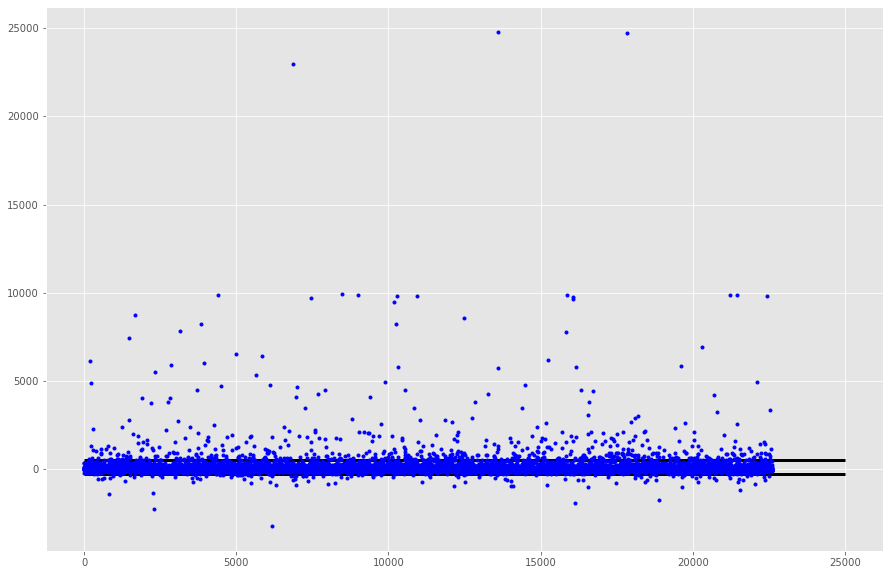

In [33]:
error = np.subtract(np.exp(predictions["truePrice"]), np.exp(predictions["predPrice"])) #Get the variance by subtracting the true and prediction
b = plt.hlines(500, xmin = 0, xmax = 25000, lw = 3) #Print a line to show variance
c = plt.hlines(-300, xmin = 0, xmax = 25000, lw = 3) #Print a lower line to show variance
a = plt.plot(error, "b.") #Plot the error
plt.show() #Show the plot

The best accuracy I could get was around 60%. This only happened when I added back longitude and latitude (which I removed since I thought the city/major area would cover that). 60% is still not the best, but considering how users can determine their own prices, it is not surprising. There are listings for 24999 and 1 in the price field, so I definitely think the hosts do not use the same criteria when determining price. 

This is for the overall data, however. I wonder if looking at different locations in isolation will provide better accuracies.

---

# Regression by City

In [34]:
#ExtractChara: extracts the desired characteristics like I did step by step for the full dataset
#Input: the area dataset
#Output: the extracted characteristics
def extractChara(data):
    characteristics = data.copy() #Take a copy of the dataframe for usage
    characteristics = characteristics.drop(columns = {"price"}) #Remove the price, since we cannot predict price if it is already there
    
    charact = characteristics.drop(columns = {"name", "hostName", "neigh", "lastReview"}) #Remove the variables discussed before

    charact = pd.get_dummies(charact) #Get the dummies for easier model training
    scale = StandardScaler() #Add a standard scaler to scale our data for easier use later
    scale.fit(charact) #Fit the scaler with our characteristics
    chara = scale.transform(charact) #Transform the data with our scaler
    
    return chara #Return the extracted characteristics

#RandomForest: build a random forest for the given area
#Input: the given characteristics, the prices, and the area this is representing
#Output: the model accuracy with the area
def randomForest(chara, price, area):
    charaATrain, charaATest, priceATrain, priceATest = train_test_split(chara, price, test_size = 0.1) #Split the data into train and test
    
    forest = RandomForestRegressor(n_estimators = 150) #Build a whole forest of trees
    forest.fit(charaATrain, priceATrain) #Fit the forest
    predictA = forest.predict(charaATest) #Get the predictions for RMSE
    
    accuracyA = forest.score(charaATest, priceATest)
    
    print("{} Accuracy: {}".format(area, accuracyA)) #Print the accuracy
    print("{} Root Mean Square Error: {}".format(area, np.sqrt(mean_squared_error(priceATest, predictA)))) #Print the root mean square error
    
    return (area, accuracyA) #Return the accuracy with the area for visualization

In [35]:
areas = bnb["city"].unique() #Get all the unique major areas
accuracies = [overallAccuracy] #Build a list to build the accuracies

for area in areas:
    areaData = bnb.loc[bnb["city"] == area] #Look only at the data for the area
    
    priceArea = areaData["price"].copy() #Take the price as its own variable. That is what we are looking for
    priceArea = np.log(priceArea) #Take the log of the set for normalization
    
    areaData = areaData.drop(columns = {"city"})
    charaArea = extractChara(areaData) #Extract the wanted characteristics
    
    accuracies.append(randomForest(charaArea, priceArea, area)) #Call the random forest function for the specific area

Asheville Accuracy: 0.4804929699089592
Asheville Root Mean Square Error: 0.5214592319013919
Austin Accuracy: 0.5617673404742662
Austin Root Mean Square Error: 0.6675173728382297
Boston Accuracy: 0.6303267758804704
Boston Root Mean Square Error: 0.4608834286762215
Miami Accuracy: 0.5853513296206289
Miami Root Mean Square Error: 0.574234270006679
Chicago Accuracy: 0.5062391620262887
Chicago Root Mean Square Error: 0.5393837319548247
Las Vegas Accuracy: 0.6389732477325876
Las Vegas Root Mean Square Error: 0.5338502587114273
Columbus Accuracy: 0.7270297851186631
Columbus Root Mean Square Error: 0.4554104499765031
Denver Accuracy: 0.503293800039186
Denver Root Mean Square Error: 0.5151054317376869
Hawaii Accuracy: 0.6213954255839036
Hawaii Root Mean Square Error: 0.4653569502693926
New York City Accuracy: 0.617483340430885
New York City Root Mean Square Error: 0.4495559545715053
Los Angeles Accuracy: 0.6366613301655641
Los Angeles Root Mean Square Error: 0.5356778679181289
Nashville Accurac

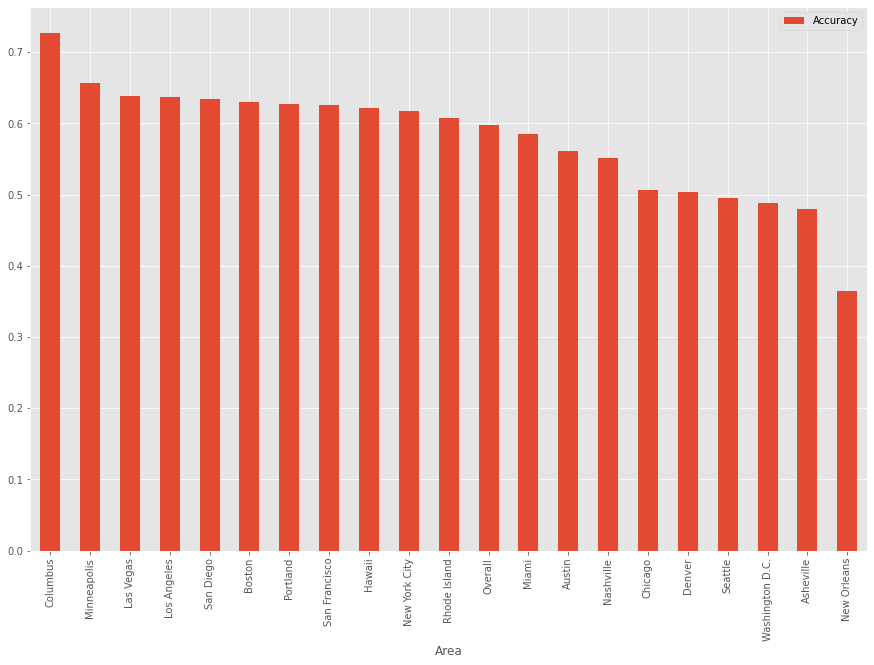

In [36]:
accDF = pd.DataFrame(accuracies, columns = ["Area", "Accuracy"]) #Put the accuracies list into a dataframe

accSort = accDF.sort_values("Accuracy", ascending = False) #Sort the accuracies datafrmame by its accuracies
accSort.plot.bar(x = "Area", y = "Accuracy") #Plot the model accuracy for each major area in a bar graph

---

# Overall Removing Extraneous Values

The max value is 24999 and the min values is 0, so all of these mean errors are going to have issues. So, I will see what happens if I remove unusually low and high values (keep 60 < x < 1000)

In [37]:
bnbTrim = bnb.loc[bnb["price"] > 20] #Trim out values lower than 20
bnbTrim = bnbTrim.loc[bnbTrim["price"] < 2000] #Trim out values higher than 1500
print("Max: ",np.max(bnbTrim["price"])) #Print the current max price
print("Min: ",np.min(bnbTrim["price"])) #Print the current min price

Max:  1999
Min:  21


In [38]:
priceTrim = bnbTrim["price"].copy() #Take the price as its own variable. That is what we are looking for
priceTrim = np.log(priceTrim) #Take the log of the set for normalization
    
charaTrim = extractChara(bnbTrim) #Extract the wanted characteristics
    
area, accuracyTrim = randomForest(charaTrim, priceTrim, "Trimmed") #Call the random forest function for the specific area

Trimmed Accuracy: 0.59393278008192
Trimmed Root Mean Square Error: 0.4973002116544767


The accuracy seems to have gone down upon removing values, which means the mean was not the problem. The root mean square error has remained below 1 every time though.

---

# Conclusion

In this project, the model only came to a 60% accuracy with the random forest, but root mean square errors remained below 1 the whole time. This likely means it cannot quite be fully predicted due the the strangeness that comes with users inputting prices. The accuracy could be higher or lower by major area, so it seems the areas are also inconsistent.

Looking at the characteristics the model determined was most important, these were roomType_Entire home/apt, longitude, latitude, id, and monthlyReviews. Of course higher monthly reviews and getting an entire house would make the price go higher. It means more people are coming in and wanting to not share the AirBNB. This makes perfect sense. The ID being here means that it depends on the property itself, which could have been hidden in the title or similar means. The method I was trying to practice just did not suit NLP. As for Latitude and Longitude, I am quite surprised. I originally cut them out since they were encompassed in the city/major area variable, but that variable never made it into the top spot, even when ignoring items like latitude and longitude. These appear to be more important in grouping major areas together rather than looking at one as a whole, which is pretty interesting.